# **Towards Ethical Consensus Methods: An Agent-agnostic Resilient and Parameter-free Approach**
## Guilherme Ramos and Emily Pereira

In [ ]:
from numpy import mean, std, average
import matplotlib.pyplot as plt
from copy import deepcopy

# MSR - mean subsequence reduce

In [397]:
def DiscardBasedConsensus(x0, adjacency_matrix, max_iterations=30, f=0, attck_vals={}):
    n = len(x0)
    ns = [0]*n
    x = x0[:]
    r = [x0.copy()]
    for a in attck_vals:
        x[a] = attck_vals[a](0)
        r[-1][a] = x[a]
    for i in range(1,max_iterations):
        for j in range(n):
            ngs = [k for k in range(n) if adjacency_matrix[k][j]]
            rps = []
            order = sorted([x[k] for k in ngs],key=lambda z:abs(z-x[j]), reverse=True)
            order = order[f:]
            s = x[j] + sum(order)
            s = s/(1+len(order))
            x[j] = s
        for a in attck_vals:
            x[a] = attck_vals[a](i+1)
        r += [x.copy()]
    return r

# Reputation-based

In [400]:
def repBasedConsensus(x0, adjacency_matrix, max_iterations=30, f=0, attck_vals=[]):
    n = len(x0)
    ns = [0]*n
    x = x0[:]
    r = [x0.copy()]
    #print(x)
    for a in attck_vals:
        x[a] = attck_vals[a](0)
        r[-1][a] = x[a]
    for i in range(1,max_iterations):
        for j in range(n):
            ngs = [k for k in range(n) if adjacency_matrix[k][j]]
            rps = []
            for k in ngs:
                rps += [(lambda z:sum(z)/len(z))([abs(x[l]-x[k]) for l in ngs+[j]])]
            order = (lambda z:z[:-f] if f > 0 else z)(sorted(range(len(rps)), key=lambda z: rps[z]))
            s = x[j] + sum([x[ngs[k]] for k in order])
            s = s/(1+len(order))
            x[j] = s
        for a in attck_vals:
            x[a] = attck_vals[a](i+1)
        r += [x.copy()]
    return r

# Agent-agnostic

In [405]:
def consensus(adj_mat, x0, attck_vals={}, nit=10):
    neigh = [[j for j in range(len(adj_mat)) if adj_mat[i][j]] for i in range(len(adj_mat))]
    r = [x0]
    adj = adj_mat #build_dob_st(adj_mat, [])
    for j in attck_vals:
        r[-1][j] = attck_vals[j](0)
    for k in range(1, nit-1):
        x = []
        for i in range(len(adj)):
            if i in attck_vals:
                x.append(attck_vals[i](k))
            else:
                vals = neigh[i]
                x_s = [r[-1][j] for j in neigh[i]]+[r[-1][i]]
                mu = mean(x_s)
                s = std(x_s)

                filtration = []
                while k > 1 and len(vals) > 1 and filtration != vals:
                    filtration = vals[:]
                    tmp = list(filter(lambda j: abs(r[-1][j]-mu) <= s, vals))
                    if len(tmp):
                        vals = tmp[:]
                        x_s = [r[-1][j] for j in vals]+[r[-1][i]]
                        mu = mean(x_s)
                        s = std(x_s)
                    else:
                        filtration = [min(vals, key=lambda j:abs(r[-1][j]-mu))]
                        break
                discard = [j for j in neigh[i] if j not in vals]
                x_s = [r[-1][j] for j in vals]+[r[-1][i]]
                x.append(average(x_s))
        r.append(x)
    return r

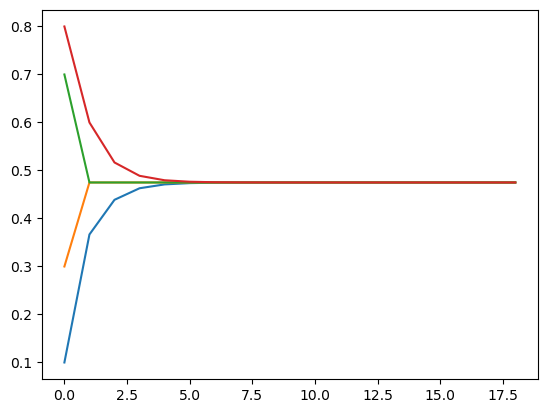

In [17]:
x0 = [.1,.3,.7,.8]
adjacency_matrix = [[0,1,1,0],[1,0,1,1],[1,1,0,1],[0,1,1,0]]

r=consensus(adjacency_matrix, x0, nit=20)

plt.plot(list(range(len(r))),list(r))
plt.show()

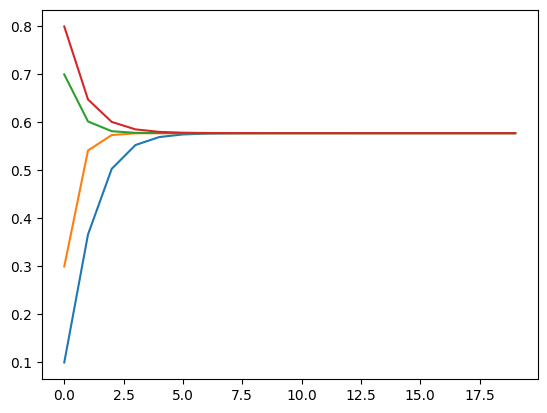

In [ ]:
x0 = [.1,.3,.7,.8]
adjacency_matrix = [[0,1,1,0],[1,0,1,1],[1,1,0,1],[0,1,1,0]]

r=DiscardBasedConsensus(x0, adjacency_matrix, max_iterations=20)

plt.plot(list(range(len(r))),list(r))
plt.show()

[0.1, 0.3, 0.7, 0.8]


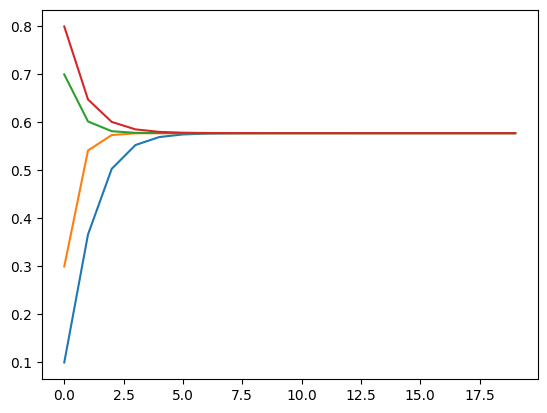

In [ ]:
x0 = [.1,.3,.7,.8]
adjacency_matrix = [[0,1,1,0],[1,0,1,1],[1,1,0,1],[0,1,1,0]]

r=repBasedConsensus(x0, adjacency_matrix, max_iterations=20)

plt.plot(list(range(len(r))),list(r))
plt.show()

## Agent-agnostic

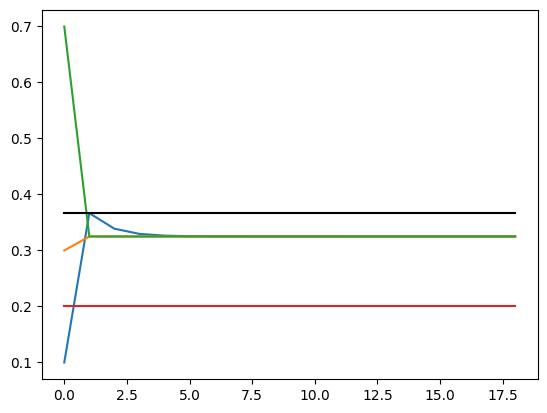

In [ ]:
att_v = {3:(lambda x:0.2)}
r = consensus(adjacency_matrix, x0, attck_vals=att_v, nit=20)
true_val = (sum(x0)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(x0)-len(att_v))
plt.plot(list(range(len(r))),list(r))
plt.plot([0,len(r)-1], [true_val, true_val],color="black")
plt.show()

In [ ]:
true_val

0.3666666666666667

## Reputation-based

[0.1, 0.2, 0.7, 0.8]


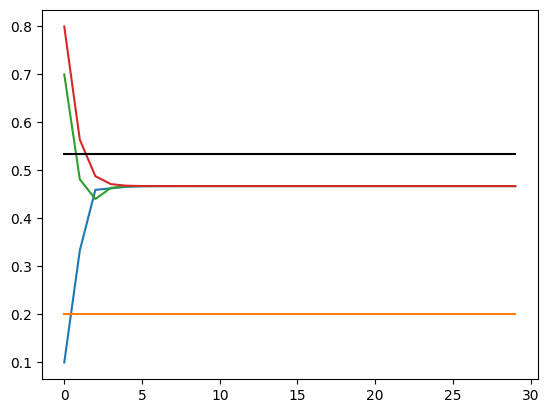

In [ ]:
att_v = {1:(lambda x:0.2)}
r=repBasedConsensus(x0, adjacency_matrix, f=1, attck_vals=att_v)
true_val = (sum(x0)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(x0)-len(att_v))
plt.plot(list(range(len(r))),list(r))
plt.plot([0,len(r)-1], [true_val, true_val],color="black")
plt.show()

## MSR

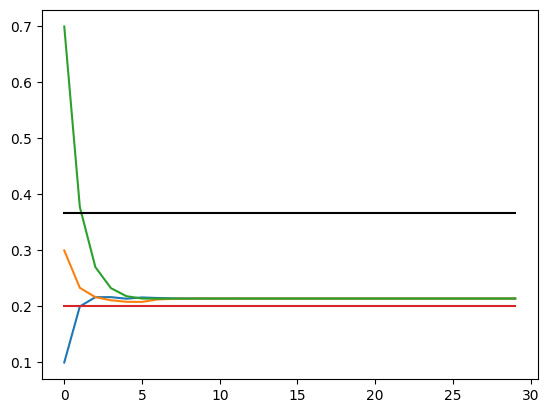

In [ ]:
att_v = {3:(lambda x:0.2)}
r = DiscardBasedConsensus(x0, adjacency_matrix, attck_vals=att_v, f=1)
true_val = (sum(x0)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(x0)-len(att_v))
plt.plot(list(range(len(r))),list(r))
plt.plot([0,len(r)-1], [true_val, true_val],color="black")
plt.show()

## Agent agnostic

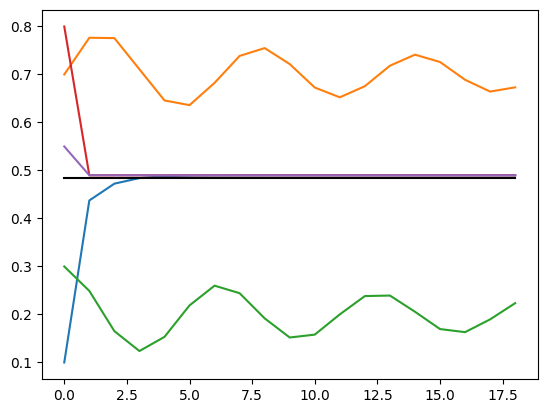

In [ ]:
from math import sin, cos
att_v = {1:(lambda x:0.7+1/(x+10)*sin(x)), 2:(lambda x:0.2+1/(x+10)*cos(x))}
xInit = x0+[.55]
res=consensus([[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], \
                                 [1, 1, 1, 0,1],[1, 1, 1, 1, 0]],xInit,\
                                   attck_vals=att_v, nit=20)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Reputation-based

[0.1, 0.3, 0.7, 0.8, 0.55]


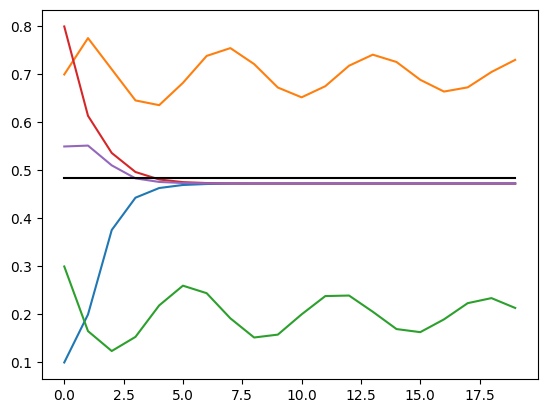

In [ ]:
from math import sin, cos
att_v = {1:(lambda x:0.7+1/(x+10)*sin(x)), 2:(lambda x:0.2+1/(x+10)*cos(x))}
xInit = x0+[.55]
res=repBasedConsensus(xInit,[[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], \
                                 [1, 1, 1, 0,1],[1, 1, 1, 1, 0]], f=2,\
                                   attck_vals=att_v, max_iterations=20)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## MSR

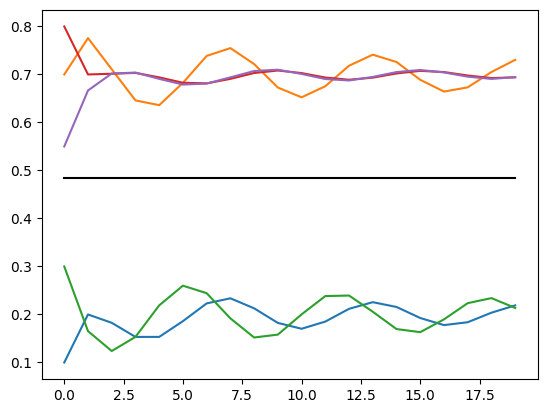

In [ ]:
from math import sin, cos
att_v = {1:(lambda x:0.7+1/(x+10)*sin(x)), 2:(lambda x:0.2+1/(x+10)*cos(x))}
xInit = x0+[.55]
res=DiscardBasedConsensus(xInit,[[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], \
                                 [1, 1, 1, 0,1],[1, 1, 1, 1, 0]], f=2,\
                                   attck_vals=att_v, max_iterations=20)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Agent-agnostic

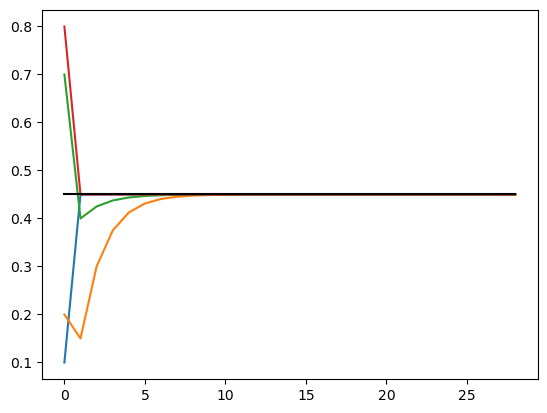

In [ ]:
att_v = {}
xInit = x0[:4]

res=consensus([[0,1,1,1],[1,0,0,0],[1,0,0,0],[1,0,0,0]],xInit, nit=30)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Consensus-based

[0.1, 0.2, 0.7, 0.8]


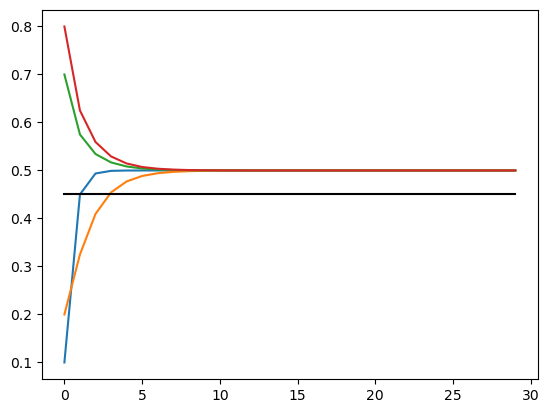

In [ ]:
att_v = {}
xInit = x0[:4]

res=repBasedConsensus(xInit,[[0,1,1,1],[1,0,0,0],[1,0,0,0],[1,0,0,0]], max_iterations=30)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## MSR

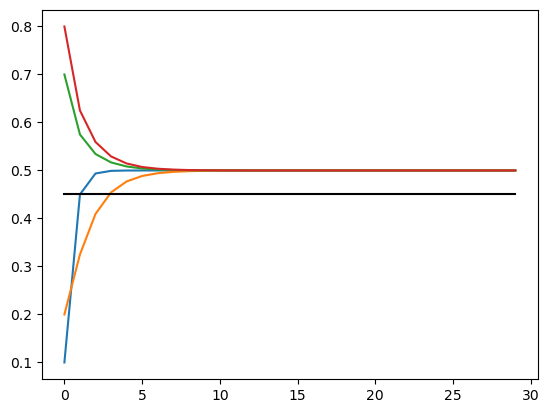

In [ ]:
att_v = {}
xInit = x0[:4]

res=DiscardBasedConsensus(xInit,[[0,1,1,1],[1,0,0,0],[1,0,0,0],[1,0,0,0]], max_iterations=30)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Agent-agnostic

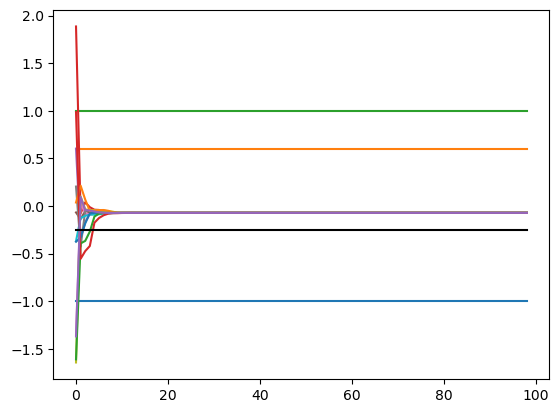

In [ ]:
adj_matrix = [[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0], [1, 0, 0, 1, 1, 1, 1,
  0, 1, 0, 1, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
  0], [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], [1, 1, 0, 1, 0,
  1, 1, 1, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
  0, 0, 1], [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0], [0, 0, 1,
  0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
  1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], [0,
  1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 0, 1, 1, 0, 0, 0,
  0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
  1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], [0, 1, 0, 1, 1,
  1, 0, 1, 0, 0, 1, 0, 1, 1, 0]]
xInit = [-1.04694, -0.00216506, -0.897521, 1.88615, 0.603284, -0.0669066, \
-1.35135, 0.20474, -1.64277, -0.367927, -0.374351, 0.0373047, \
-1.61005, 0.985223, -1.36896]
att_v = {0:(lambda x:-1.),1:(lambda x:0.6),2:(lambda x:1)}

res=consensus(adj_matrix,xInit, attck_vals=att_v,nit=100)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Reputation-based

[-1.0, 0.6, 1, 1.88615, 0.603284, -0.0669066, -1.35135, 0.20474, -1.64277, -0.367927, -0.374351, 0.0373047, -1.61005, 0.985223, -1.36896]


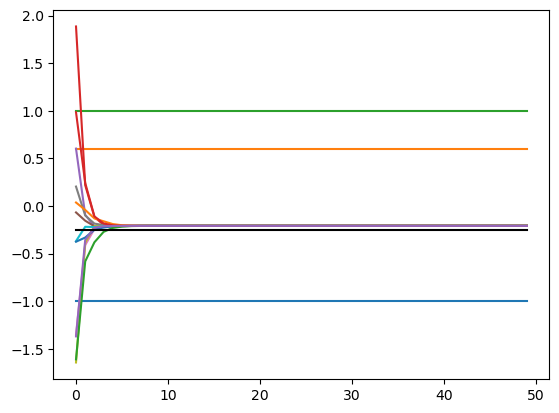

In [ ]:
res=repBasedConsensus(xInit, adj_matrix,attck_vals=att_v, f=3, max_iterations=50)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## MSR

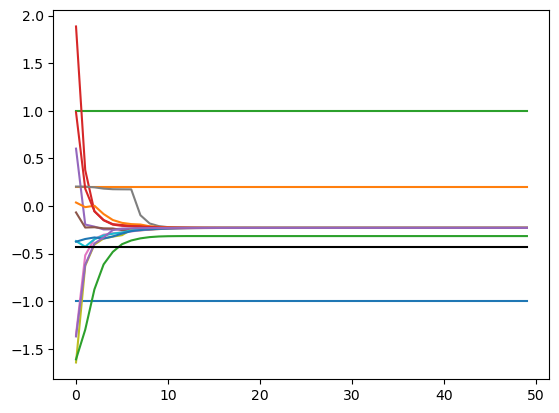

In [ ]:
adj_matrix = [[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0], [1, 0, 0, 1, 1, 1, 1,
  0, 1, 0, 1, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
  0], [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], [1, 1, 0, 1, 0,
  1, 1, 1, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
  0, 0, 1], [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0], [0, 0, 1,
  0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
  1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], [0,
  1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 0, 1, 1, 0, 0, 0,
  0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
  1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], [0, 1, 0, 1, 1,
  1, 0, 1, 0, 0, 1, 0, 1, 1, 0]]
xInit = [-1.04694, -0.00216506, -0.897521, 1.88615, 0.603284, -0.0669066, \
-1.35135, 0.20474, -1.64277, -0.367927, -0.374351, 0.0373047, \
-1.61005, 0.985223, -1.36896]
att_v = {0:(lambda x:-1.),1:(lambda x:0.2),2:(lambda x:1)}

res=DiscardBasedConsensus(xInit, adj_matrix,attck_vals=att_v, f=3, max_iterations=50)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Agent-agnostic

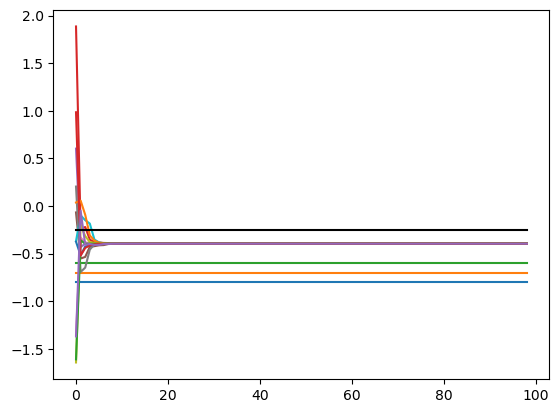

In [ ]:
adj_matrix = [[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0], [1, 0, 0, 1, 1, 1, 1,
  0, 1, 0, 1, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
  0], [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], [1, 1, 0, 1, 0,
  1, 1, 1, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
  0, 0, 1], [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0], [0, 0, 1,
  0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
  1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], [0,
  1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 0, 1, 1, 0, 0, 0,
  0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
  1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], [0, 1, 0, 1, 1,
  1, 0, 1, 0, 0, 1, 0, 1, 1, 0]]
xInit = [-1.04694, -0.00216506, -0.897521, 1.88615, 0.603284, -0.0669066, \
-1.35135, 0.20474, -1.64277, -0.367927, -0.374351, 0.0373047, \
-1.61005, 0.985223, -1.36896]
att_v = {0:(lambda x:-.8),1:(lambda x:-.7),2:(lambda x:-.6)}

res=consensus(adj_matrix,xInit, attck_vals=att_v,nit=100)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## Reputation-based

[-0.8, -0.7, -0.6, 1.88615, 0.603284, -0.0669066, -1.35135, 0.20474, -1.64277, -0.367927, -0.374351, 0.0373047, -1.61005, 0.985223, -1.36896]


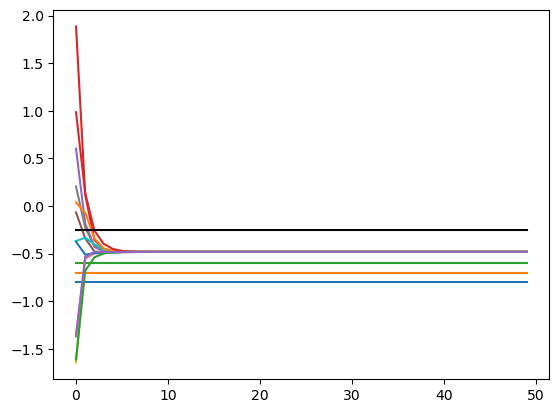

In [ ]:
res=repBasedConsensus(xInit, adj_matrix,attck_vals=att_v, f=3, max_iterations=50)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()

## MSR

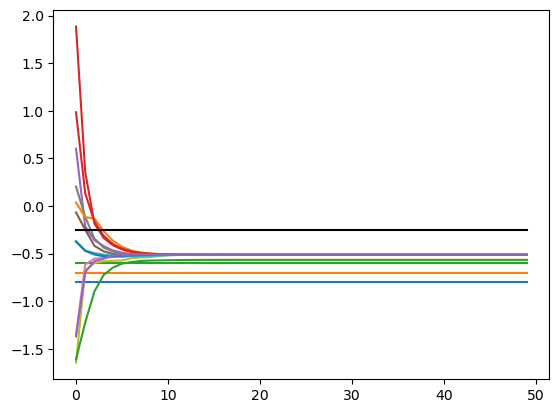

In [ ]:
res=DiscardBasedConsensus(xInit, adj_matrix,attck_vals=att_v, f=3, max_iterations=50)
true_val = (sum(xInit)-sum(list(map(lambda f:f(0), att_v.values()))))/(len(xInit)-len(att_v))
plt.plot(list(range(len(res))),list(res))
plt.plot([0,len(res)-1], [true_val, true_val],color="black")
plt.show()